# Model and Data Evaluation

Using one of three Kaggle datasets, do some exploratory data analysis to gain insight into the data and explore various machine learning models.

The datasets contain the following features collected from room occupancy sensors:
- temperature
- humidity
- CO2 
- ambient light 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Read the csv file and inspect the data

In [2]:
df = pd.read_csv('../../../data/room-occupancy/room-occupancy-2.csv')
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20560 non-null  object 
 1   Temperature    20560 non-null  float64
 2   Humidity       20560 non-null  float64
 3   Light          20560 non-null  float64
 4   CO2            20560 non-null  float64
 5   HumidityRatio  20560 non-null  float64
 6   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ MB


In [4]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


In [5]:
df['Occupancy'].value_counts()

0    15810
1     4750
Name: Occupancy, dtype: int64

In [6]:
df.corr()['Occupancy']

Temperature      0.555610
Humidity         0.046240
Light            0.914850
CO2              0.501582
HumidityRatio    0.257324
Occupancy        1.000000
Name: Occupancy, dtype: float64

Key takeaways so far:

- stong correlation between ambient light and occupancy
- the data set is unbalanced (36% occupied, 64% vacant)
- value ranges for the features are several orders of magnitude different

Given the strong correlation of ambient light to occupancy detection we need to make sure there is sufficient data where occupancy is true but ambient light is low. Similarly, sufficient data where occupancy is false and ambient light high. Otherwise model might be heavily biased.

Lets plot each of the features, color coding Occupancy.

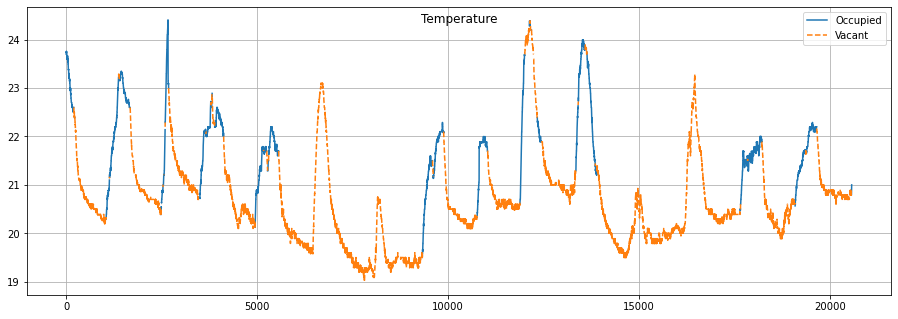

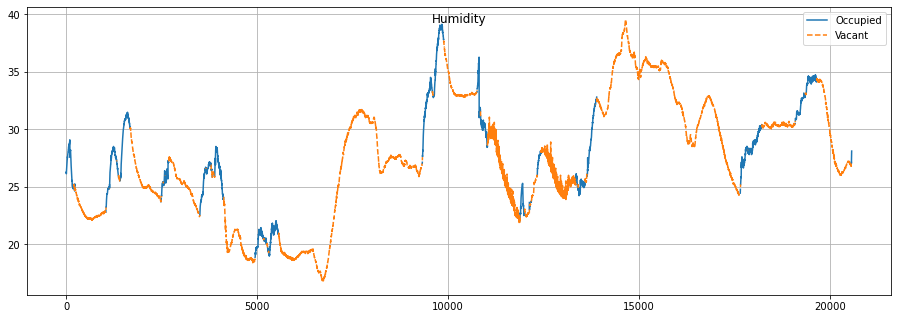

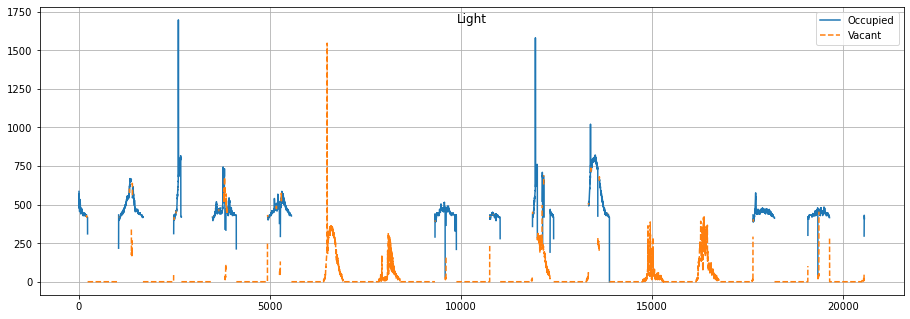

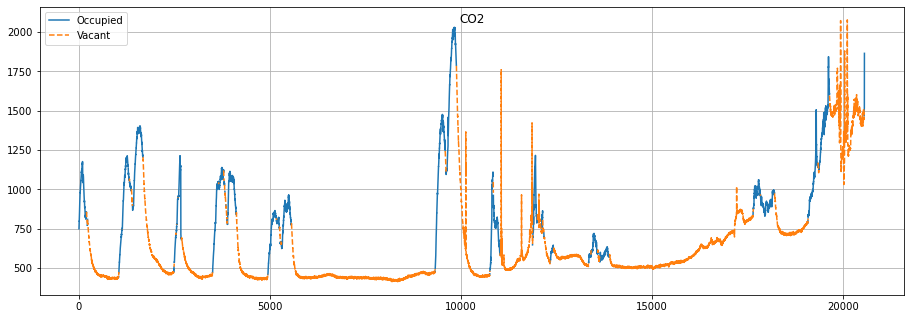

In [7]:
def plot_feature(df, feature):
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_axes([0,0,1,1])
    
    fig.suptitle(feature)
    ax.plot(np.where(df.Occupancy==1, df[feature], None), label='Occupied')
    ax.plot(np.where(df.Occupancy==0, df[feature], None), label='Vacant', ls='--')
    ax.grid()
    ax.legend()


for i in range(1, 5):
    plot_feature(df, df.columns[i])

In the ambient light plot, there appears to be very few data points where lights are on and the room is vacant or lights are off and the room is occupied. This will bias any model that uses this feature. 

Since occupancy in a dimly lit room and vacancy in a lighted room are both legitimate use cases, we should try to train a model on temp, humidity, and CO2 only. **Drop the Light column**

In [8]:
# comment out 'date' for room-occupancy.csv, only needed for -2
df.drop(['Light'], axis=1, inplace=True)
df.drop(['date'], axis=1, inplace=True)
df.head()

,Temperature,Humidity,CO2,HumidityRatio,Occupancy
0,23.7000,26.272,749.200000,0.004764,1
1,23.7180,26.290,760.400000,0.004773,1
2,23.7300,26.230,769.666667,0.004765,1
3,23.7225,26.125,774.750000,0.004744,1
4,23.7540,26.200,779.000000,0.004767,1


# Experiment with Different Classifiers

Estimators might behave badly if the individual features do not more or less look like standard normally distributed data. Lets plot the distribution for each feature to make sure.

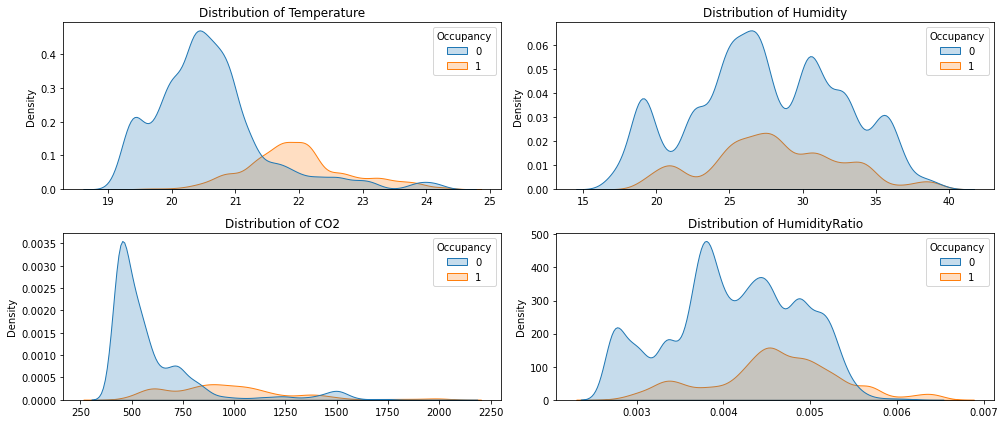

In [9]:
def plot_feature_dist(myDf):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=False, sharey=False)
    axes = axes.ravel()
    cols = myDf.columns[:]

    for col, ax in zip(cols, axes):
        data = myDf[[col, 'Occupancy']]
        sns.kdeplot(data=data, x=col, hue='Occupancy', shade=True, ax=ax)
        ax.set(title=f'Distribution of {col}', xlabel=None)

    fig.tight_layout()
    plt.show()
    
plot_feature_dist(df)

The distribution of data samples clearly does not follow a normal distribution. This dataset could benefit from a scaler transform. 

First, split the data into features (X) and labels (Y).

In [10]:
X = df[['Temperature', 'Humidity', 'CO2', 'HumidityRatio']]
Y = df['Occupancy']

Now scale the data.

ToDo: there are many preprocessing funtions to choose from, which is best?

In [11]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[0.86902928, 0.41867721, 0.20222389, 0.54973661],
       [0.87235747, 0.41946825, 0.20895567, 0.55197181],
       [0.87457627, 0.41683147, 0.21452542, 0.54999689],
       ...,
       [0.34946071, 0.48341024, 0.66641623, 0.41103049],
       [0.34946071, 0.49560536, 0.73283246, 0.42225317],
       [0.36979969, 0.49901121, 0.87227648, 0.43310214]])

Create the train/test split.

We have a bit of an imbalance in the dataset that can be resolved by stratifying the train/test split. This ensures the training and testing data sets have an equal percentage of occupied vs vacant labels.

A technique to evaluate models is K-Fold Cross-Validation. Cross-validation, a resampling procedure used to evaluate models on a limited data sample, is primarily used to estimate the skill of a machine learning model on unseen data.

Importing StratifiedKFold allows us to take advantage of both techniques.

Now create a K-Fold split and loop through each index.

In [12]:
from sklearn.model_selection import StratifiedKFold

splits = 20
skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=67)

**Try each classifier against the Stratified K-Fold split and examine stats**

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

lr = LogisticRegression(random_state=67)
knn = KNeighborsClassifier(n_neighbors=int(np.sqrt(len(X_scaled))))
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
svm = SVC(probability=True)

lr_scores_stratified = []
knn_scores_stratified = []
dt_scores_stratified = []
rf_scores_stratified = []
svm_scores_stratified = []

for train_index, test_index in skf.split(X_scaled, Y):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = Y[train_index], Y[test_index]
    lr.fit(X_train_fold, y_train_fold)
    knn.fit(X_train_fold, y_train_fold)
    dt.fit(X_train_fold, y_train_fold)
    rf.fit(X_train_fold, y_train_fold)
    svm.fit(X_train_fold, y_train_fold)
    lr_scores_stratified.append(lr.score(X_test_fold, y_test_fold))
    knn_scores_stratified.append(knn.score(X_test_fold, y_test_fold))
    dt_scores_stratified.append(dt.score(X_test_fold, y_test_fold))
    rf_scores_stratified.append(rf.score(X_test_fold, y_test_fold))
    svm_scores_stratified.append(svm.score(X_test_fold, y_test_fold))

print('\nLogistical Regression model:')
print('   Highest accuracy:', max(lr_scores_stratified)*100, '%')
print('   Lowest Accuracy:', min(lr_scores_stratified)*100, '%')
print('   Mean Accuracy:', np.mean(lr_scores_stratified)*100, '%')
print('   Standard Deviation:', np.std(lr_scores_stratified)*100, '%')
print('\nK-Nearest Neighbors model:')
print('   Highest accuracy:', max(knn_scores_stratified)*100, '%')
print('   Lowest Accuracy:', min(knn_scores_stratified)*100, '%')
print('   Mean Accuracy:', np.mean(knn_scores_stratified)*100, '%')
print('   Standard Deviation:', np.std(knn_scores_stratified)*100, '%')
print('\nDecision Tree model:')
print('   Highest accuracy:', max(dt_scores_stratified)*100, '%')
print('   Lowest Accuracy:', min(dt_scores_stratified)*100, '%')
print('   Mean Accuracy:', np.mean(dt_scores_stratified)*100, '%')
print('   Standard Deviation:', np.std(dt_scores_stratified)*100, '%')
print('\nRandom Forest model:')
print('   Highest accuracy:', max(rf_scores_stratified)*100, '%')
print('   Lowest Accuracy:', min(rf_scores_stratified)*100, '%')
print('   Mean Accuracy:', np.mean(rf_scores_stratified)*100, '%')
print('   Standard Deviation:', np.std(rf_scores_stratified)*100, '%')
print('\nSupport Vector Machine model:')
print('   Highest accuracy:', max(svm_scores_stratified)*100, '%')
print('   Lowest Accuracy:', min(svm_scores_stratified)*100, '%')
print('   Mean Accuracy:', np.mean(svm_scores_stratified)*100, '%')
print('   Standard Deviation:', np.std(svm_scores_stratified)*100, '%')


Logistical Regression model:
   Highest accuracy: 83.85214007782102 %
   Lowest Accuracy: 80.93385214007782 %
   Mean Accuracy: 82.45136186770428 %
   Standard Deviation: 0.805339378825651 %

K-Nearest Neighbors model:
   Highest accuracy: 94.16342412451361 %
   Lowest Accuracy: 91.14785992217898 %
   Mean Accuracy: 92.64105058365759 %
   Standard Deviation: 0.7940240270616403 %

Decision Tree model:
   Highest accuracy: 98.92996108949417 %
   Lowest Accuracy: 96.88715953307393 %
   Mean Accuracy: 97.99124513618678 %
   Standard Deviation: 0.4647678314553942 %

Random Forest model:
   Highest accuracy: 99.22178988326849 %
   Lowest Accuracy: 97.47081712062257 %
   Mean Accuracy: 98.60894941634241 %
   Standard Deviation: 0.4448195861935304 %

Support Vector Machine model:
   Highest accuracy: 92.80155642023347 %
   Lowest Accuracy: 89.78599221789884 %
   Mean Accuracy: 91.32782101167315 %
   Standard Deviation: 0.8481882273930128 %


In [14]:
scores_df = pd.DataFrame()
scores_df['Logistical Regression'] = lr_scores_stratified
scores_df['K-Nearest Neighbor'] = knn_scores_stratified
scores_df['Decision Tree'] = dt_scores_stratified
scores_df['Random Forest'] = rf_scores_stratified
scores_df['Support Vector'] = svm_scores_stratified
scores_df = scores_df * 100

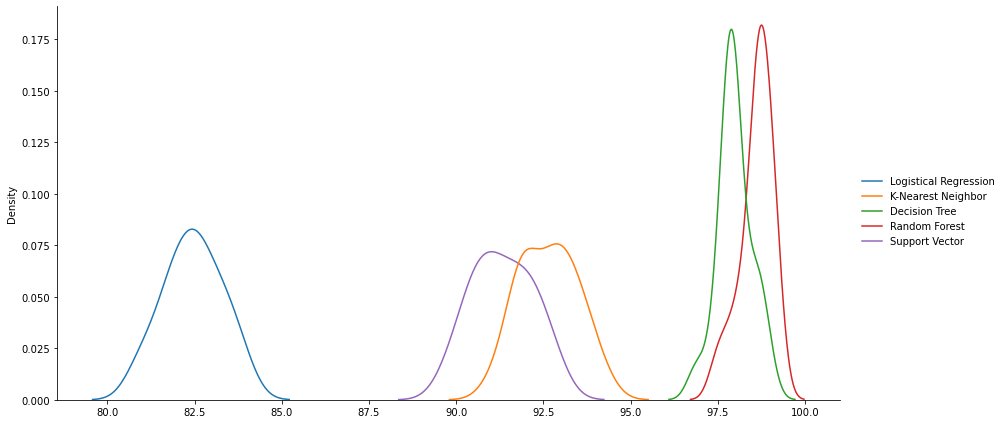

In [17]:
sns.displot(data=scores_df, kind='kde', height=6, aspect=2)

**Classifier Observations**

The Random Forest classifier is the superior model with the lowest deviation of accuracy scores. 

# Evaluate the Random Forest Model

Lets start over with a new Random forest classifier and train on a 75/25 stratified split of the X_scaled data.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)

rf = RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.25, random_state=67, stratify=Y)

rf.fit(X_train, y_train)

rf_pred, rf_score = rf.predict(X_test), rf.score(X_test, y_test)

print('Accuracy:', rf_score*100, '%')

Accuracy: 98.3657587548638 %


In [19]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3952
           1       0.97      0.96      0.96      1188

    accuracy                           0.98      5140
   macro avg       0.98      0.98      0.98      5140
weighted avg       0.98      0.98      0.98      5140



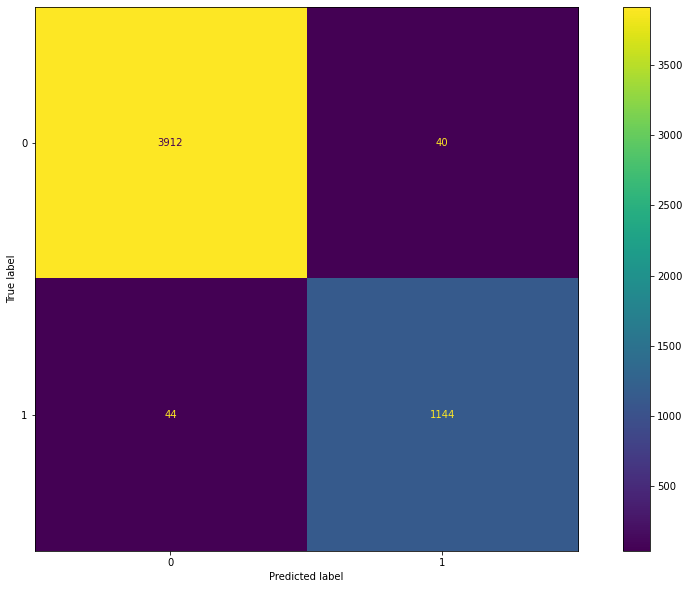

In [21]:
# plot a confusion matrix
#  TN   FP    Off-Vacant        On-vacant
#  FN   TP    Off-occupied      On-Occupied
cm = confusion_matrix(y_test, rf_pred)
cm_display = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(16,10))
cm_display.plot(ax=ax)